In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random

In [3]:
# Angles (3) + Accel (3) + Compass(3)
#TODO 2 imus in so double data width?
#data_input_width = 3 + 3 + 3
data_input_width = 3 #use only angles for now
time_steps= 10

# Input Format
# [angles(t-time_steps+1), accel(t-time_steps+1), compass(t-time_steps+1)]
# ...
# [angles(t-2), accel(t-2), compass(t-2)]
# [angles(t-1), accel(t-1), compass(t-1)]
# [angles(t) accel(t), compass(t)]

#output Format
#
# [correct_exercise, overcompensation]
#

In [4]:
model = keras.Sequential()
#TODO I don't know if simpleRNN should come before or after LSTM
#TODO another input second IMU?
model.add(layers.SimpleRNN(32, input_shape = (time_steps, data_input_width), return_sequences=True))
model.add(layers.LSTM(16))
model.add(layers.Dense(10))
#model.add(layers.Dense(2, activation='sigmoid')) #sigmoid has output between 0 and 1 (confidence)
model.add(layers.Dense(1, activation='sigmoid')) #sigmoid has output between 0 and 1 (confidence)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 32)            1152      
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4,469
Trainable params: 4,469
Non-trainable params: 0
_________________________________________________________________


In [5]:
def convertToMatrix(data, step):
    X = []
    for i in range(len(data) - step):
        d = i+step
        X.append(data[i:d,])
    return np.array(X)

def read_format_csv(filename):
    ignore_cols = ("time","IMU#","accelx","accely","accelz","compassx","compassy","compassz")
    data = pd.read_csv(filename)

    for col in ignore_cols:
        data.pop(col)

    return np.array(data)

def get_in(filename):
    inputs = convertToMatrix(read_format_csv(filename), time_steps)
    return inputs

def get_expect(inputs, over_comp):
    if over_comp:
        #TODO maybe only when input.angle > some threshold 
        outputs = np.ones(len(inputs))
    else:
        outputs = np.zeros(len(inputs))
    return outputs

#inputs = get_in("./data_simple./imu0_10_27_0.csv")
#outputs = get_expect(inputs)
#print(inputs)
#print(outputs)


In [6]:

training_file_names_imu0 = glob("./data/abduction_train/overcomp/imu0/*")
training_file_names_imu0.extend(glob("./data/abduction_train/reg/imu0/*"))

validation_file_names_imu0 = glob("./data/abduction_validate/overcomp/imu0/*")
validation_file_names_imu0.extend(glob("./data/abduction_validate/reg/imu0/*"))

epochs = 10
files_per_epoch = len(training_file_names_imu0)
files_per_val = len(validation_file_names_imu0)

training_file_names_imu1 = [i.replace("imu0", "imu1") for i in training_file_names_imu0]
validation_file_names_imu1 = [i.replace("imu0", "imu1") for i in validation_file_names_imu0]

training_index = list(range(0, files_per_epoch))
validation_index = list(range(0, files_per_val))

def training_generator():
    for j in range(epochs):
        random.shuffle(training_index)
        for i in range(files_per_epoch):
            file_name_imu0 = training_file_names_imu0[training_index[i]]
            file_name_imu1 = training_file_names_imu1[training_index[i]]
            temp_in = get_in(file_name_imu0)
            temp_out = get_expect(temp_in, "overcomp" in file_name_imu0)
            yield (temp_in, temp_out)

def validation_generator():
     for j in range(epochs):
        random.shuffle(validation_index)
        for i in range(files_per_val):
            file_name_imu0 = validation_file_names_imu0[validation_index[i]]
            file_name_imu1 = validation_file_names_imu1[validation_index[i]]
            temp_in = get_in(file_name_imu0)
            temp_out = get_expect(temp_in, "overcomp" in file_name_imu0)
            yield (temp_in, temp_out)




In [7]:
tf.config.experimental_functions_run_eagerly = False
history = model.fit(
    x=training_generator(), 
    epochs=epochs,
    steps_per_epoch=files_per_epoch,
    validation_data=validation_generator(),
    validation_steps=files_per_val,
    validation_freq=2
)

model.save("temp_model")



Epoch 1/10
89/89 [==============================] - 6s 23ms/step - loss: 0.1692
Epoch 2/10
89/89 [==============================] - 3s 29ms/step - loss: 0.1042 - val_loss: 0.0794
Epoch 3/10
89/89 [==============================] - 2s 23ms/step - loss: 0.0927: 0s - loss:
Epoch 4/10
89/89 [==============================] - 2s 24ms/step - loss: 0.0846 - val_loss: 0.0663
Epoch 5/10
89/89 [==============================] - 2s 23ms/step - loss: 0.0827
Epoch 6/10
89/89 [==============================] - 2s 24ms/step - loss: 0.0753 - val_loss: 0.0857
Epoch 7/10
89/89 [==============================] - 2s 23ms/step - loss: 0.0722
Epoch 8/10
89/89 [==============================] - 2s 24ms/step - loss: 0.0698 - val_loss: 0.1056
Epoch 9/10
89/89 [==============================] - 2s 23ms/step - loss: 0.0689
Epoch 10/10
89/89 [==============================] - 2s 24ms/step - loss: 0.0625 - val_loss: 0.0750


INFO:tensorflow:Assets written to: temp_model\assets


INFO:tensorflow:Assets written to: temp_model\assets


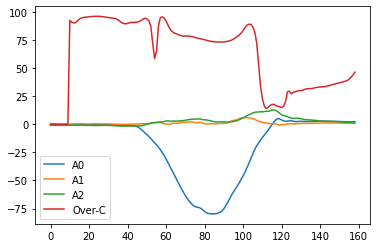

In [12]:
#file_name = "./data/abduction_validate/reg/imu0/imu0_18_17__15.csv"
#file_name = "./data/abduction_validate/overcomp/imu0/imu0_21_9__15.csv"

#file_name = "./data/abduction_validate/reg/imu0/imu0_18_17__29.csv"
#file_name = "./data/abduction_validate/overcomp/imu0/imu0_21_9__29.csv"
file_name = "./../../../MATLAB/capstone_v2/IMUExperiments/Test4/imu0_13_19__2.csv"

input_data = read_format_csv(file_name)

angle0 = input_data.flatten()[::3]
angle1 = input_data.flatten()[1::3]
angle2 = input_data.flatten()[2::3]

data_in = get_in(file_name) 
prediction = model.predict(data_in)
x_points = np.arange(0,len(angle0))

#prediction_wrong = prediction.flatten()[::2]
#prediction_comp = prediction.flatten()[1::2]
prediction_comp = prediction.flatten()

for i in range(time_steps):
    #prediction_wrong = np.insert(prediction_wrong, 0, 0)
    prediction_comp = np.insert(prediction_comp, 0, 0)

#prediction_wrong *= 100
prediction_comp *= 100

plt.plot(x_points, angle0, label="A0")
plt.plot(x_points, angle1, label="A1")
plt.plot(x_points, angle2, label="A2")
#plt.plot(x_points, prediction_wrong, label="Wrong")
plt.plot(x_points, prediction_comp, label="Over-C")
plt.legend()
plt.show()

